In [1]:
def katz_index(nx_graph,non_edges):
    to_return = []
    import networkx as nx
    import networkit as nk
    # convert to a Networkit graph
    nk_graph = nk.Graph(len(nx_graph), weighted=True)
    from collections import defaultdict

    # Define a defaultdict with default value as 0
    d = defaultdict(int)
    i = 1
    
    for node in nx_graph.nodes():
        if d[node] == 0:
            i +=1
            d[node] = i
        nk_graph.addNode()
        
    # add edges to Networkit graph
    for edge in nx_graph.edges():
        u, v = edge
        

        nk_graph.addEdge(d[u], d[v])

    katz = nk.linkprediction.KatzIndex(nk_graph)
    
    for elem in non_edges:
        to_return.append(katz.run(d[elem[0]], d[elem[1]]))
    return to_return

In [2]:
def topology_based(path):
    import json
  
    # Opening JSON file
    f = open(path)

    # returns JSON object as 
    # a dictionary
    data = json.load(f)

    # Closing file
    f.close()
    content = data['data']
    first = content[0]
    second = first['spans']

    triplets = [] #head, link, tail ---> process(spanID), operationName, process(references_spanID)
    
    dict_span_process = {}
    for elem in second:
        dict_span_process[elem['spanID']] = first['processes'][elem['processID']]['serviceName']

    root = first['traceID']

    for elem in second:
        head = elem['spanID']
        link = elem['operationName']
        tail = None
        if head != root:
            tail = elem['references'][0]['spanID']
            triplets.append([dict_span_process[head],link,dict_span_process[tail]])
        
    import networkx as nx
    import matplotlib.pyplot as plt
    import math
    # Create a graph object
    G = nx.Graph()
    
    services_set= set()
    for triplet in triplets:
        services_set.add(triplet[0])
        services_set.add(triplet[2])
    labelsDict = {}
    for elem in services_set:
        G.add_node(elem)
        labelsDict[elem] = elem
    for triplet in triplets:
        G.add_edge(triplet[0], triplet[2], label=triplet[1])
        
    node_size = 5000
    font_size = 15
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
    fig = plt.figure(1, figsize=(20, 20), dpi=400)
    # Use NetworkX's built-in drawing function to visualize the graph
    pos = nx.spring_layout(G,seed = 545)
    nx.draw_networkx_edges(G,pos,arrowstyle="-|>",arrowsize=10,width=1,arrows=True,node_size=node_size)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'label'),font_size = font_size,bbox = bbox,
                                verticalalignment = 'center_baseline')

    nx.draw(G,pos, labels=labelsDict, with_labels = True,node_size=node_size,font_size = font_size,bbox = bbox,node_color='k')
    plt.show()
    for triplet in triplets:
        print(triplet)
        
        
        

    non_edges = list(nx.non_edges(G))

    print(non_edges)
    print("Common Neighbours")
    preds = nx.common_neighbor_centrality(G,alpha=1)
    for u, v, p in preds:
        print(f"({u}, {v}) -> {p:.8f}")
        
    print("Sorensen Index")
    for elem in non_edges:
        common_neighbors = list(nx.common_neighbors(G, elem[0], elem[1]))
        sorensen_index = (2 * len(common_neighbors)) / (G.degree(elem[0]) + G.degree(elem[1]))
        print(f"({elem[0]}, {elem[1]}) -> {sorensen_index :.8f}")
    
    print("Salton Index")
    for elem in non_edges:
        common_neighbors = list(nx.common_neighbors(G, elem[0], elem[1]))
        salton_index = len(common_neighbors) / math.sqrt(G.degree(elem[0]) * G.degree(elem[1]))
        print(f"({elem[0]}, {elem[1]}) -> {salton_index :.8f}")
    
    print("Jaccard Index")
    preds = nx.jaccard_coefficient(G)
    for u, v, p in preds:
        print(f"({u}, {v}) -> {p:.8f}")
        
    print("Resouce Allocation")
    preds = nx.resource_allocation_index(G)
    for u, v, p in preds:
        print(f"({u}, {v}) -> {p:.8f}")
    
    print("Adamic Adar")
    preds = nx.adamic_adar_index(G)
    for u, v, p in preds:
        print(f"({u}, {v}) -> {p:.8f}")
        
        
    import numpy as np
    from numpy.linalg import inv

    print("Katz Index")
    katz_list = katz_index(G,non_edges)
    for elem in zip(non_edges,katz_list):
        print(f"({elem[0][0]}, {elem[0][1]}) -> {elem[1] :.8f}")
    
    print("LHN Index")
    for elem in zip(non_edges,katz_list):
        print(f"({elem[0][0]}, {elem[0][1]}) -> {elem[1]*2*len(G)/(G.degree(elem[0][0]) * G.degree(elem [0][1])) :.8f}")
    


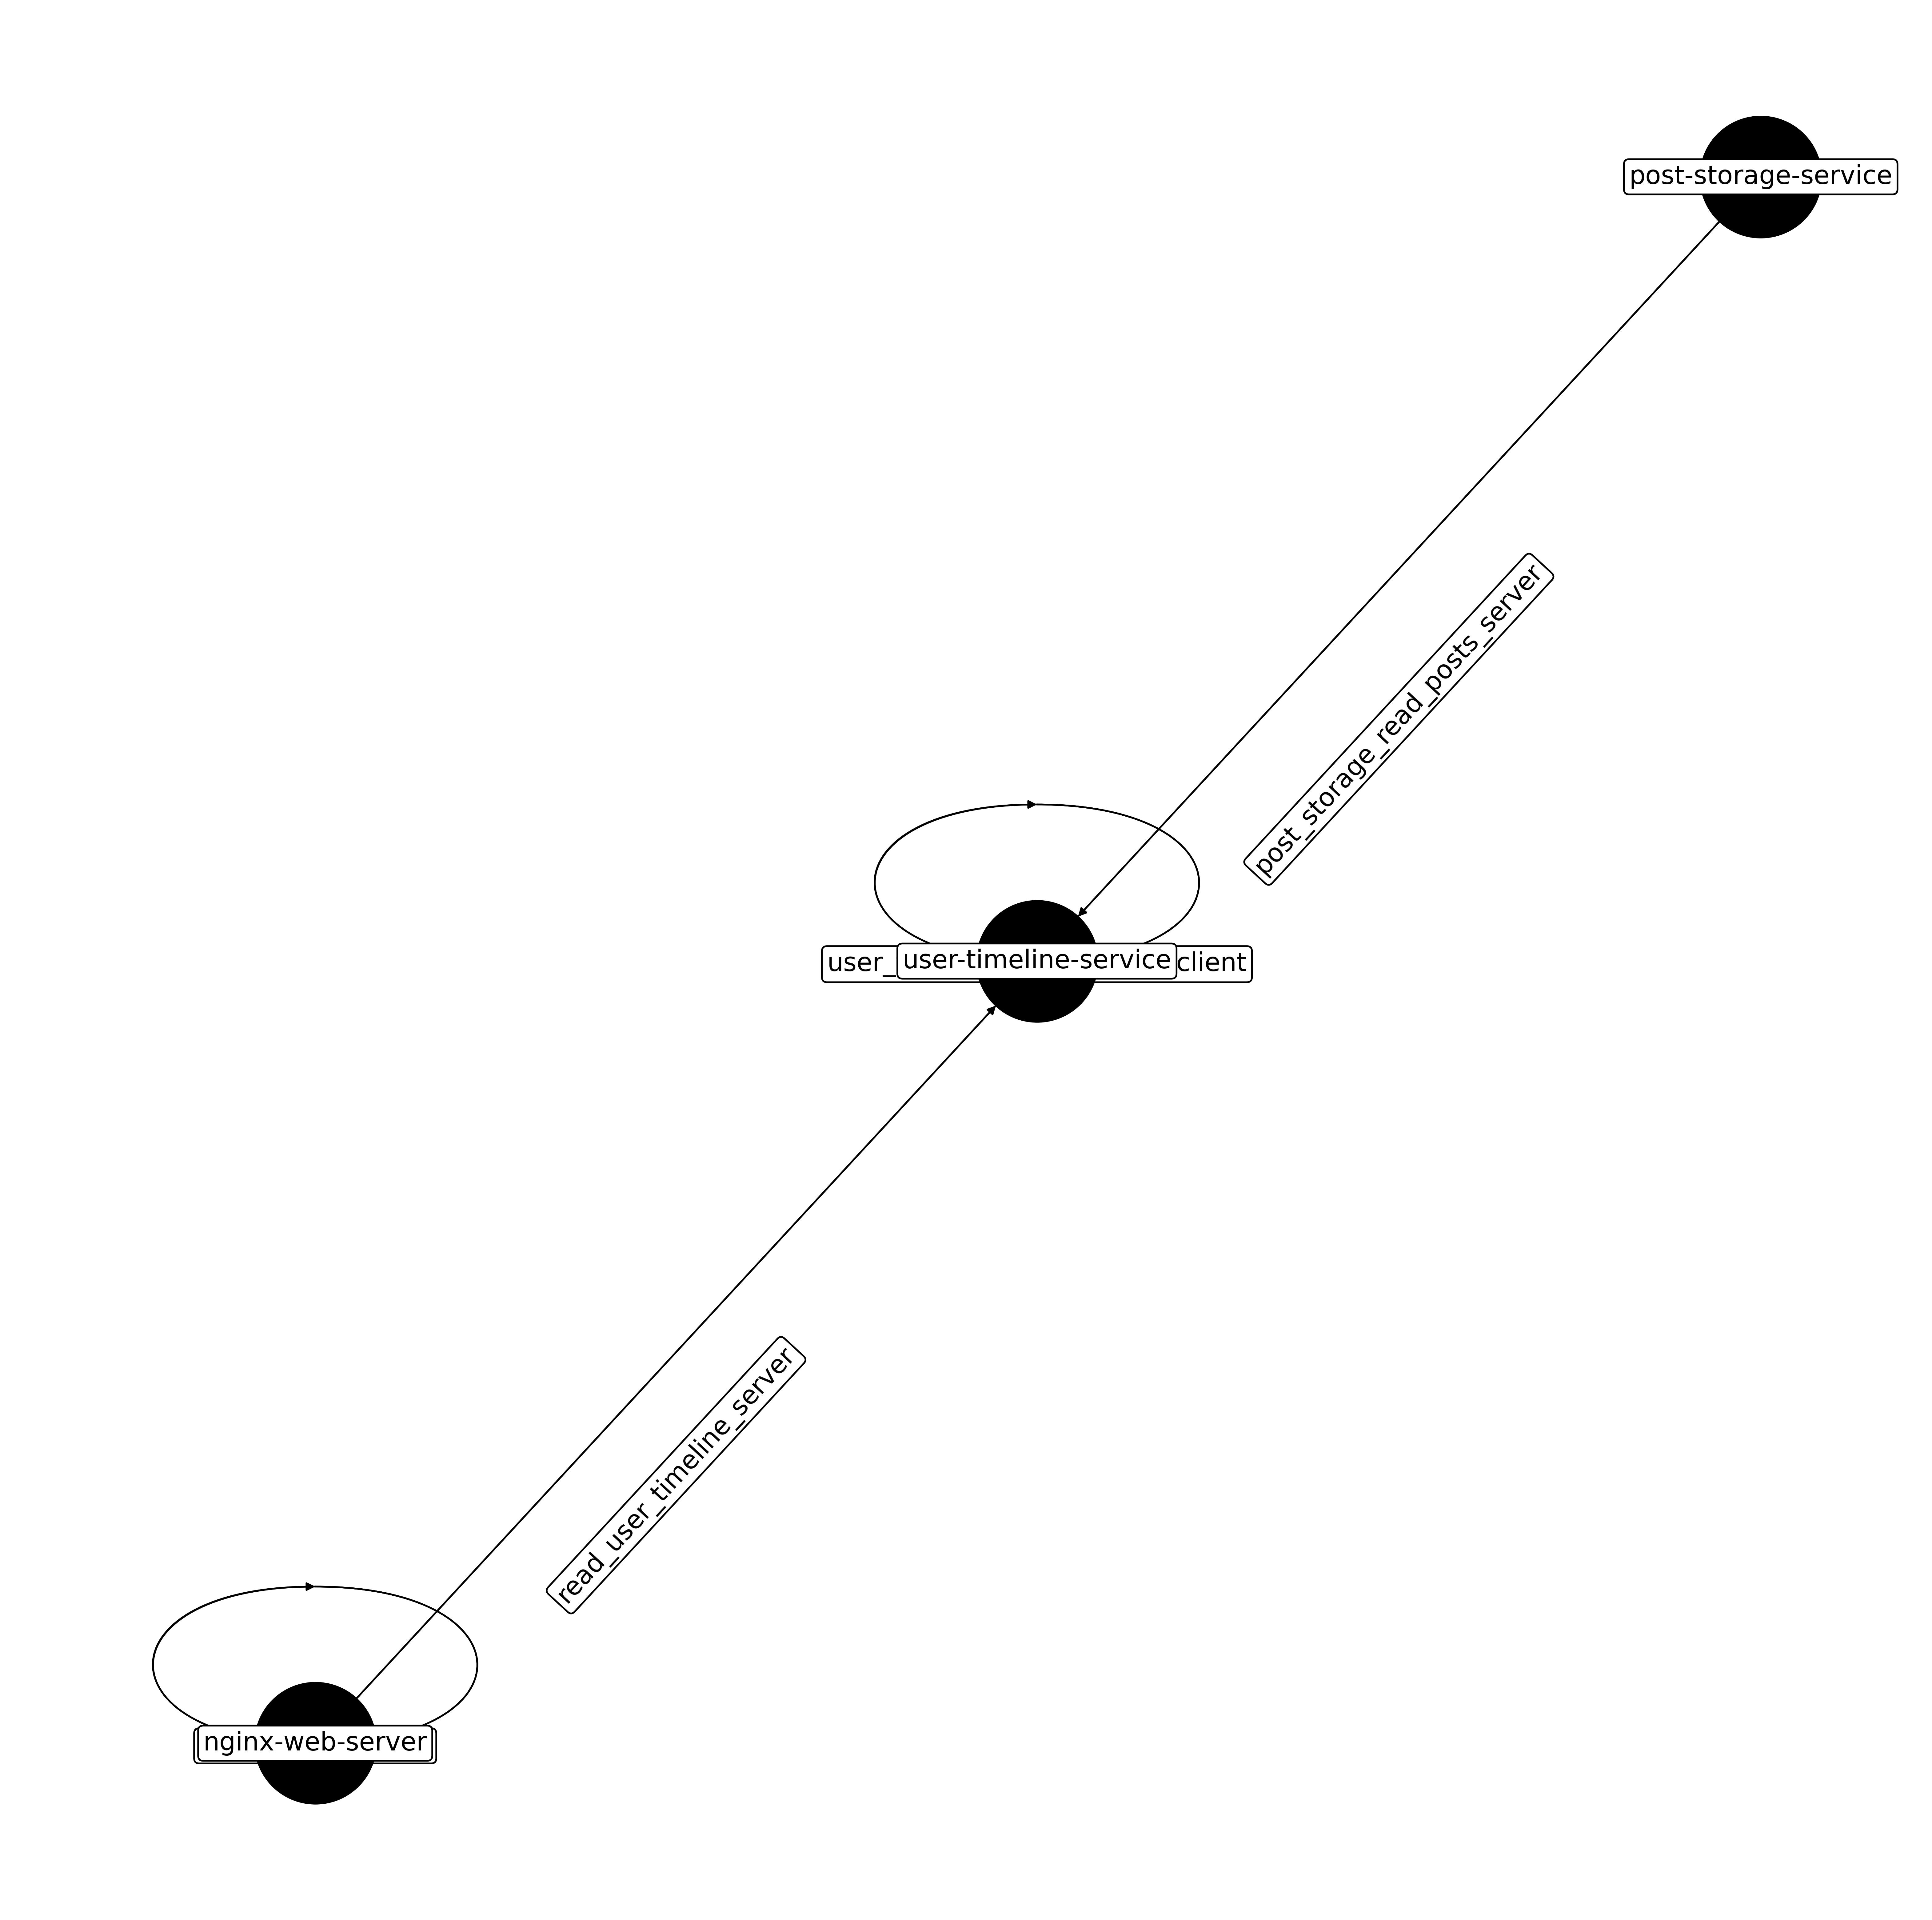

['nginx-web-server', '/wrk2-api/user-timeline/read', 'nginx-web-server']
['post-storage-service', 'post_storage_read_posts_server', 'user-timeline-service']
['nginx-web-server', 'ReadUserTimeline', 'nginx-web-server']
['user-timeline-service', 'user_timeline_redis_find_client', 'user-timeline-service']
['user-timeline-service', 'user_timeline_mongo_find_client', 'user-timeline-service']
['user-timeline-service', 'read_user_timeline_server', 'nginx-web-server']
[('post-storage-service', 'nginx-web-server')]
Common Neighbours
(post-storage-service, nginx-web-server) -> 1.00000000
Sorensen Index
(post-storage-service, nginx-web-server) -> 0.50000000
Salton Index
(post-storage-service, nginx-web-server) -> 0.57735027
Jaccard Index
(post-storage-service, nginx-web-server) -> 0.50000000
Resouce Allocation
(post-storage-service, nginx-web-server) -> 0.25000000
Adamic Adar
(post-storage-service, nginx-web-server) -> 0.72134752
Katz Index


(post-storage-service, nginx-web-server) -> 0.00002525
LHN Index
(post-storage-service, nginx-web-server) -> 0.00005050


In [3]:
topology_based('social-network/sample-rate-100/user-timeline-service.json')

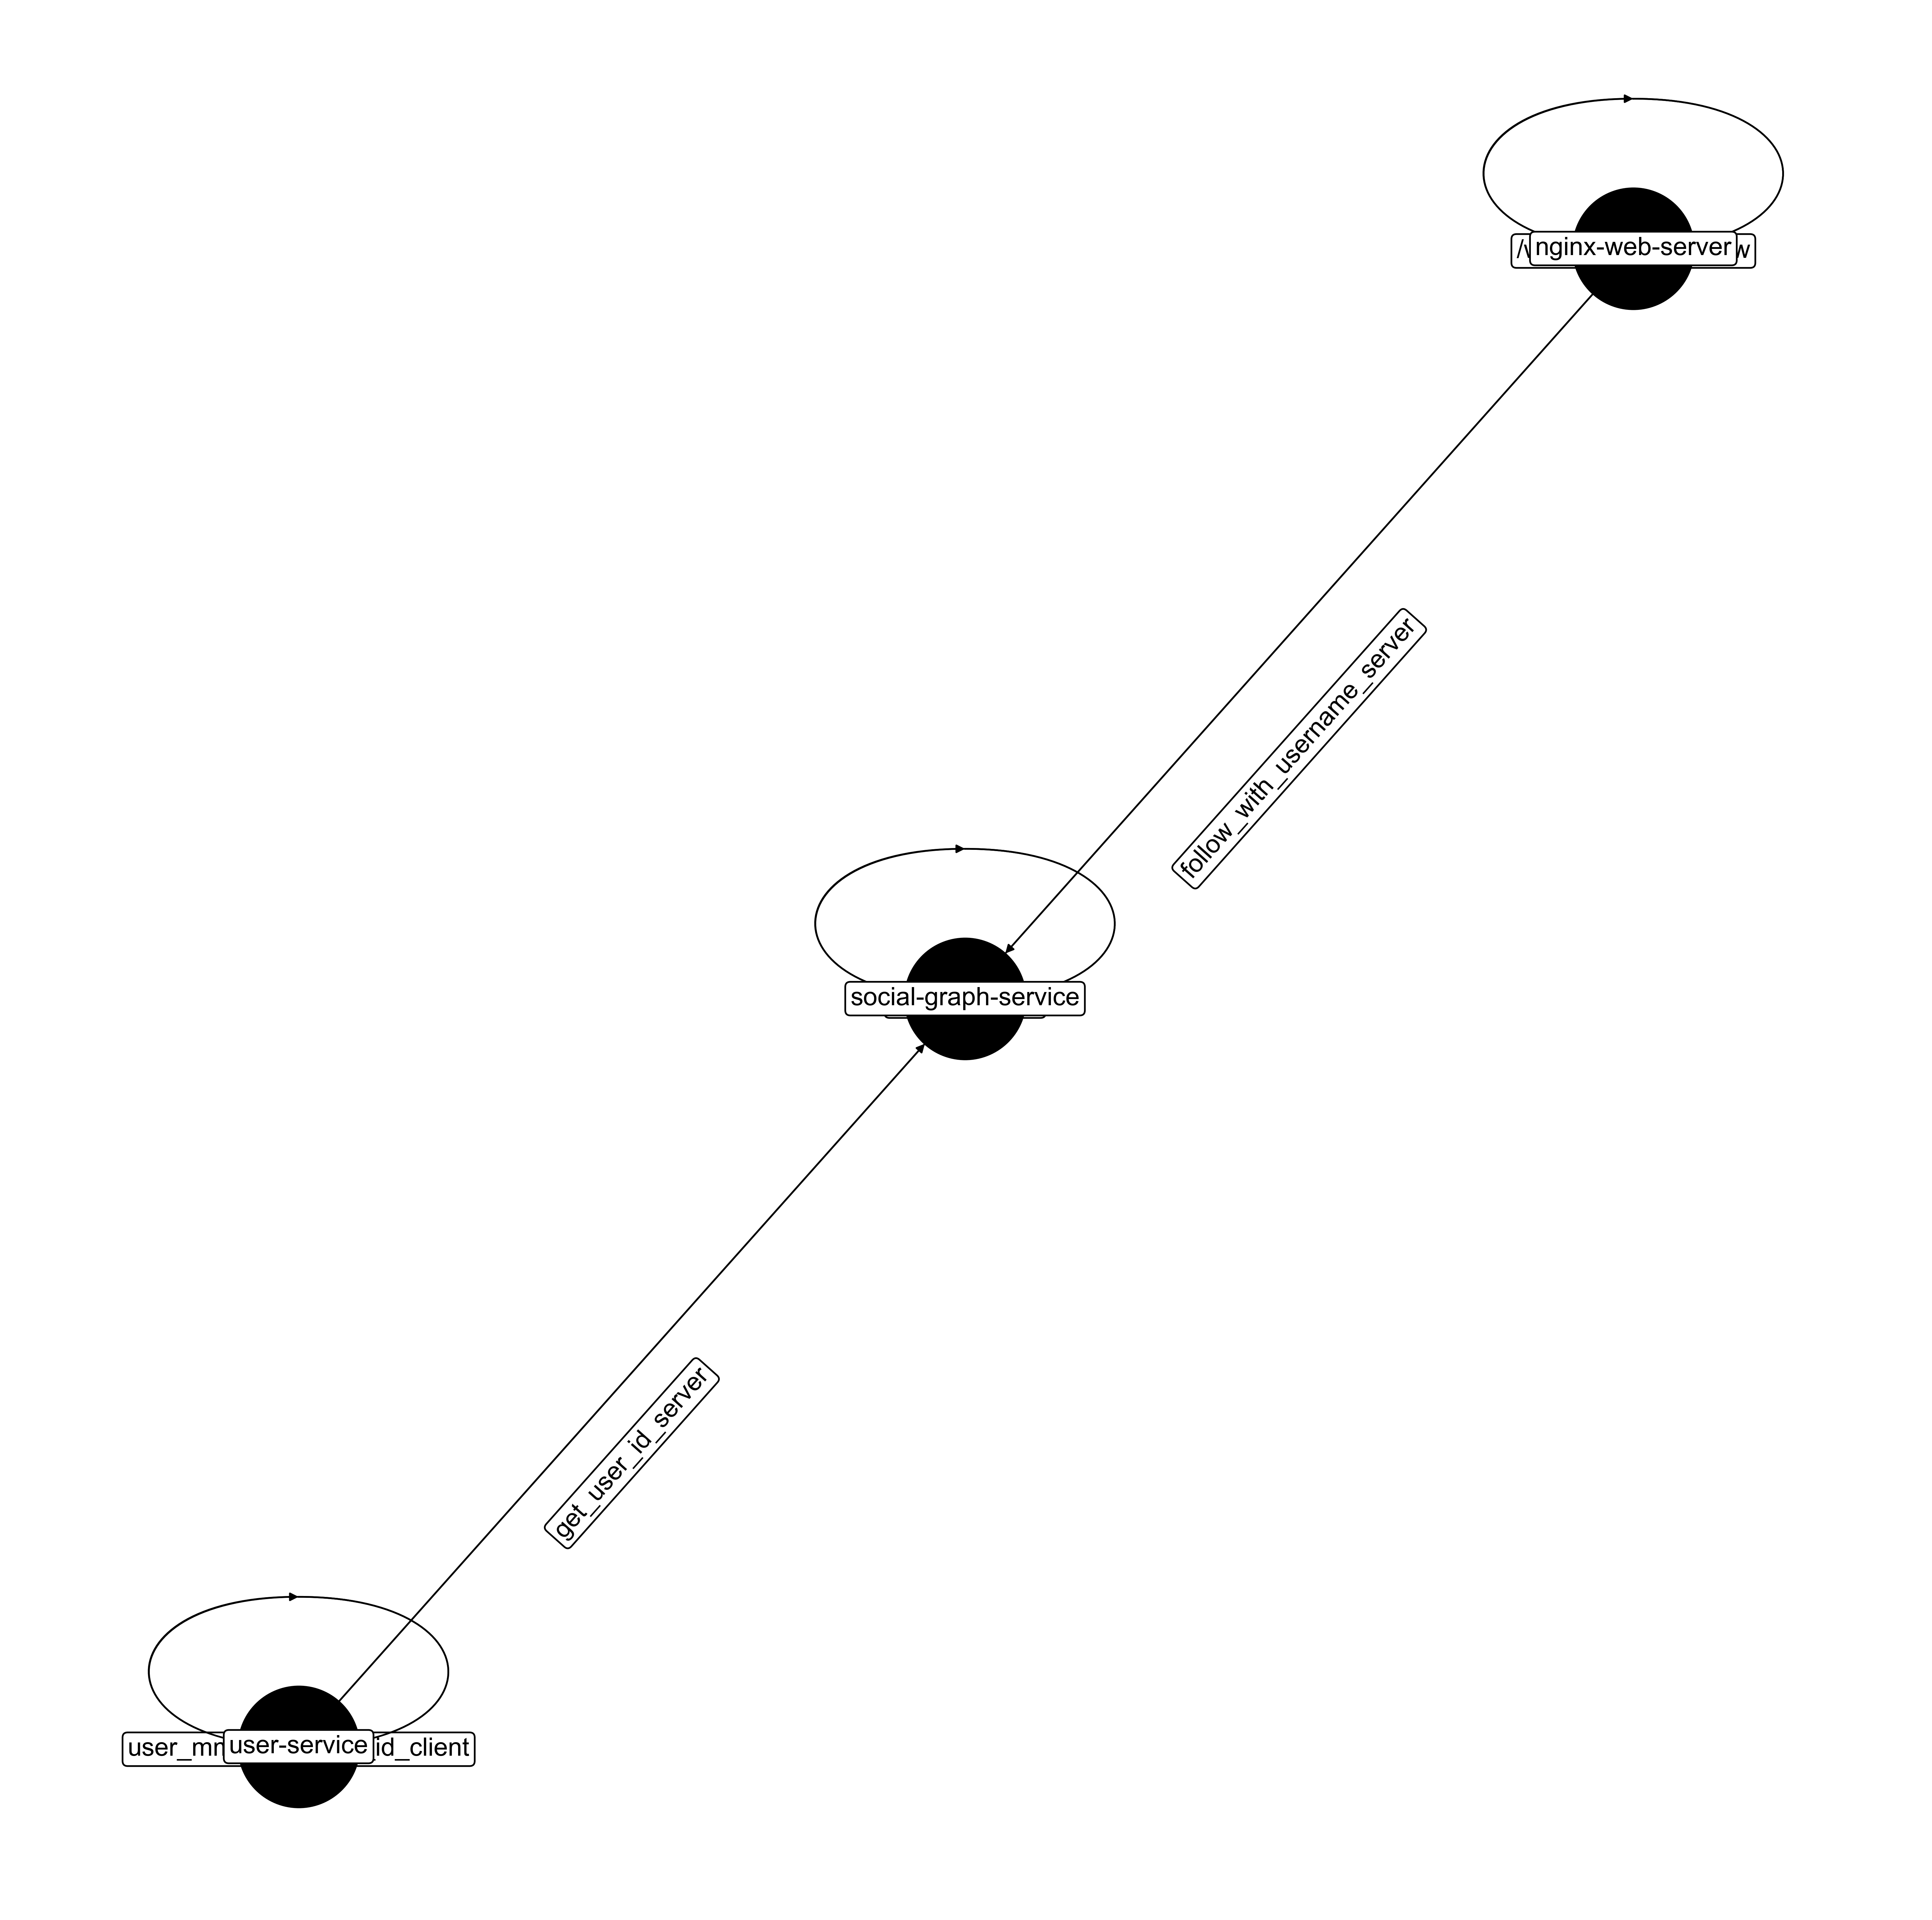

['nginx-web-server', 'Follow', 'nginx-web-server']
['nginx-web-server', '/wrk2-api/user/follow', 'nginx-web-server']
['user-service', 'user_mmc_get_user_id_client', 'user-service']
['user-service', 'get_user_id_server', 'social-graph-service']
['user-service', 'user_mmc_get_user_id_client', 'user-service']
['user-service', 'get_user_id_server', 'social-graph-service']
['social-graph-service', 'mongo_update_client', 'social-graph-service']
['social-graph-service', 'social_graph_redis_update_client', 'social-graph-service']
['social-graph-service', 'social_graph_mongo_update_client', 'social-graph-service']
['social-graph-service', 'follow_server', 'social-graph-service']
['social-graph-service', 'follow_with_username_server', 'nginx-web-server']
[('nginx-web-server', 'user-service')]
Common Neighbours
(nginx-web-server, user-service) -> 1.00000000
Sorensen Index
(nginx-web-server, user-service) -> 0.33333333
Salton Index
(nginx-web-server, user-service) -> 0.33333333
Jaccard Index
(ngin

In [4]:
topology_based('social-network/sample-rate-100/social-graph-service.json')

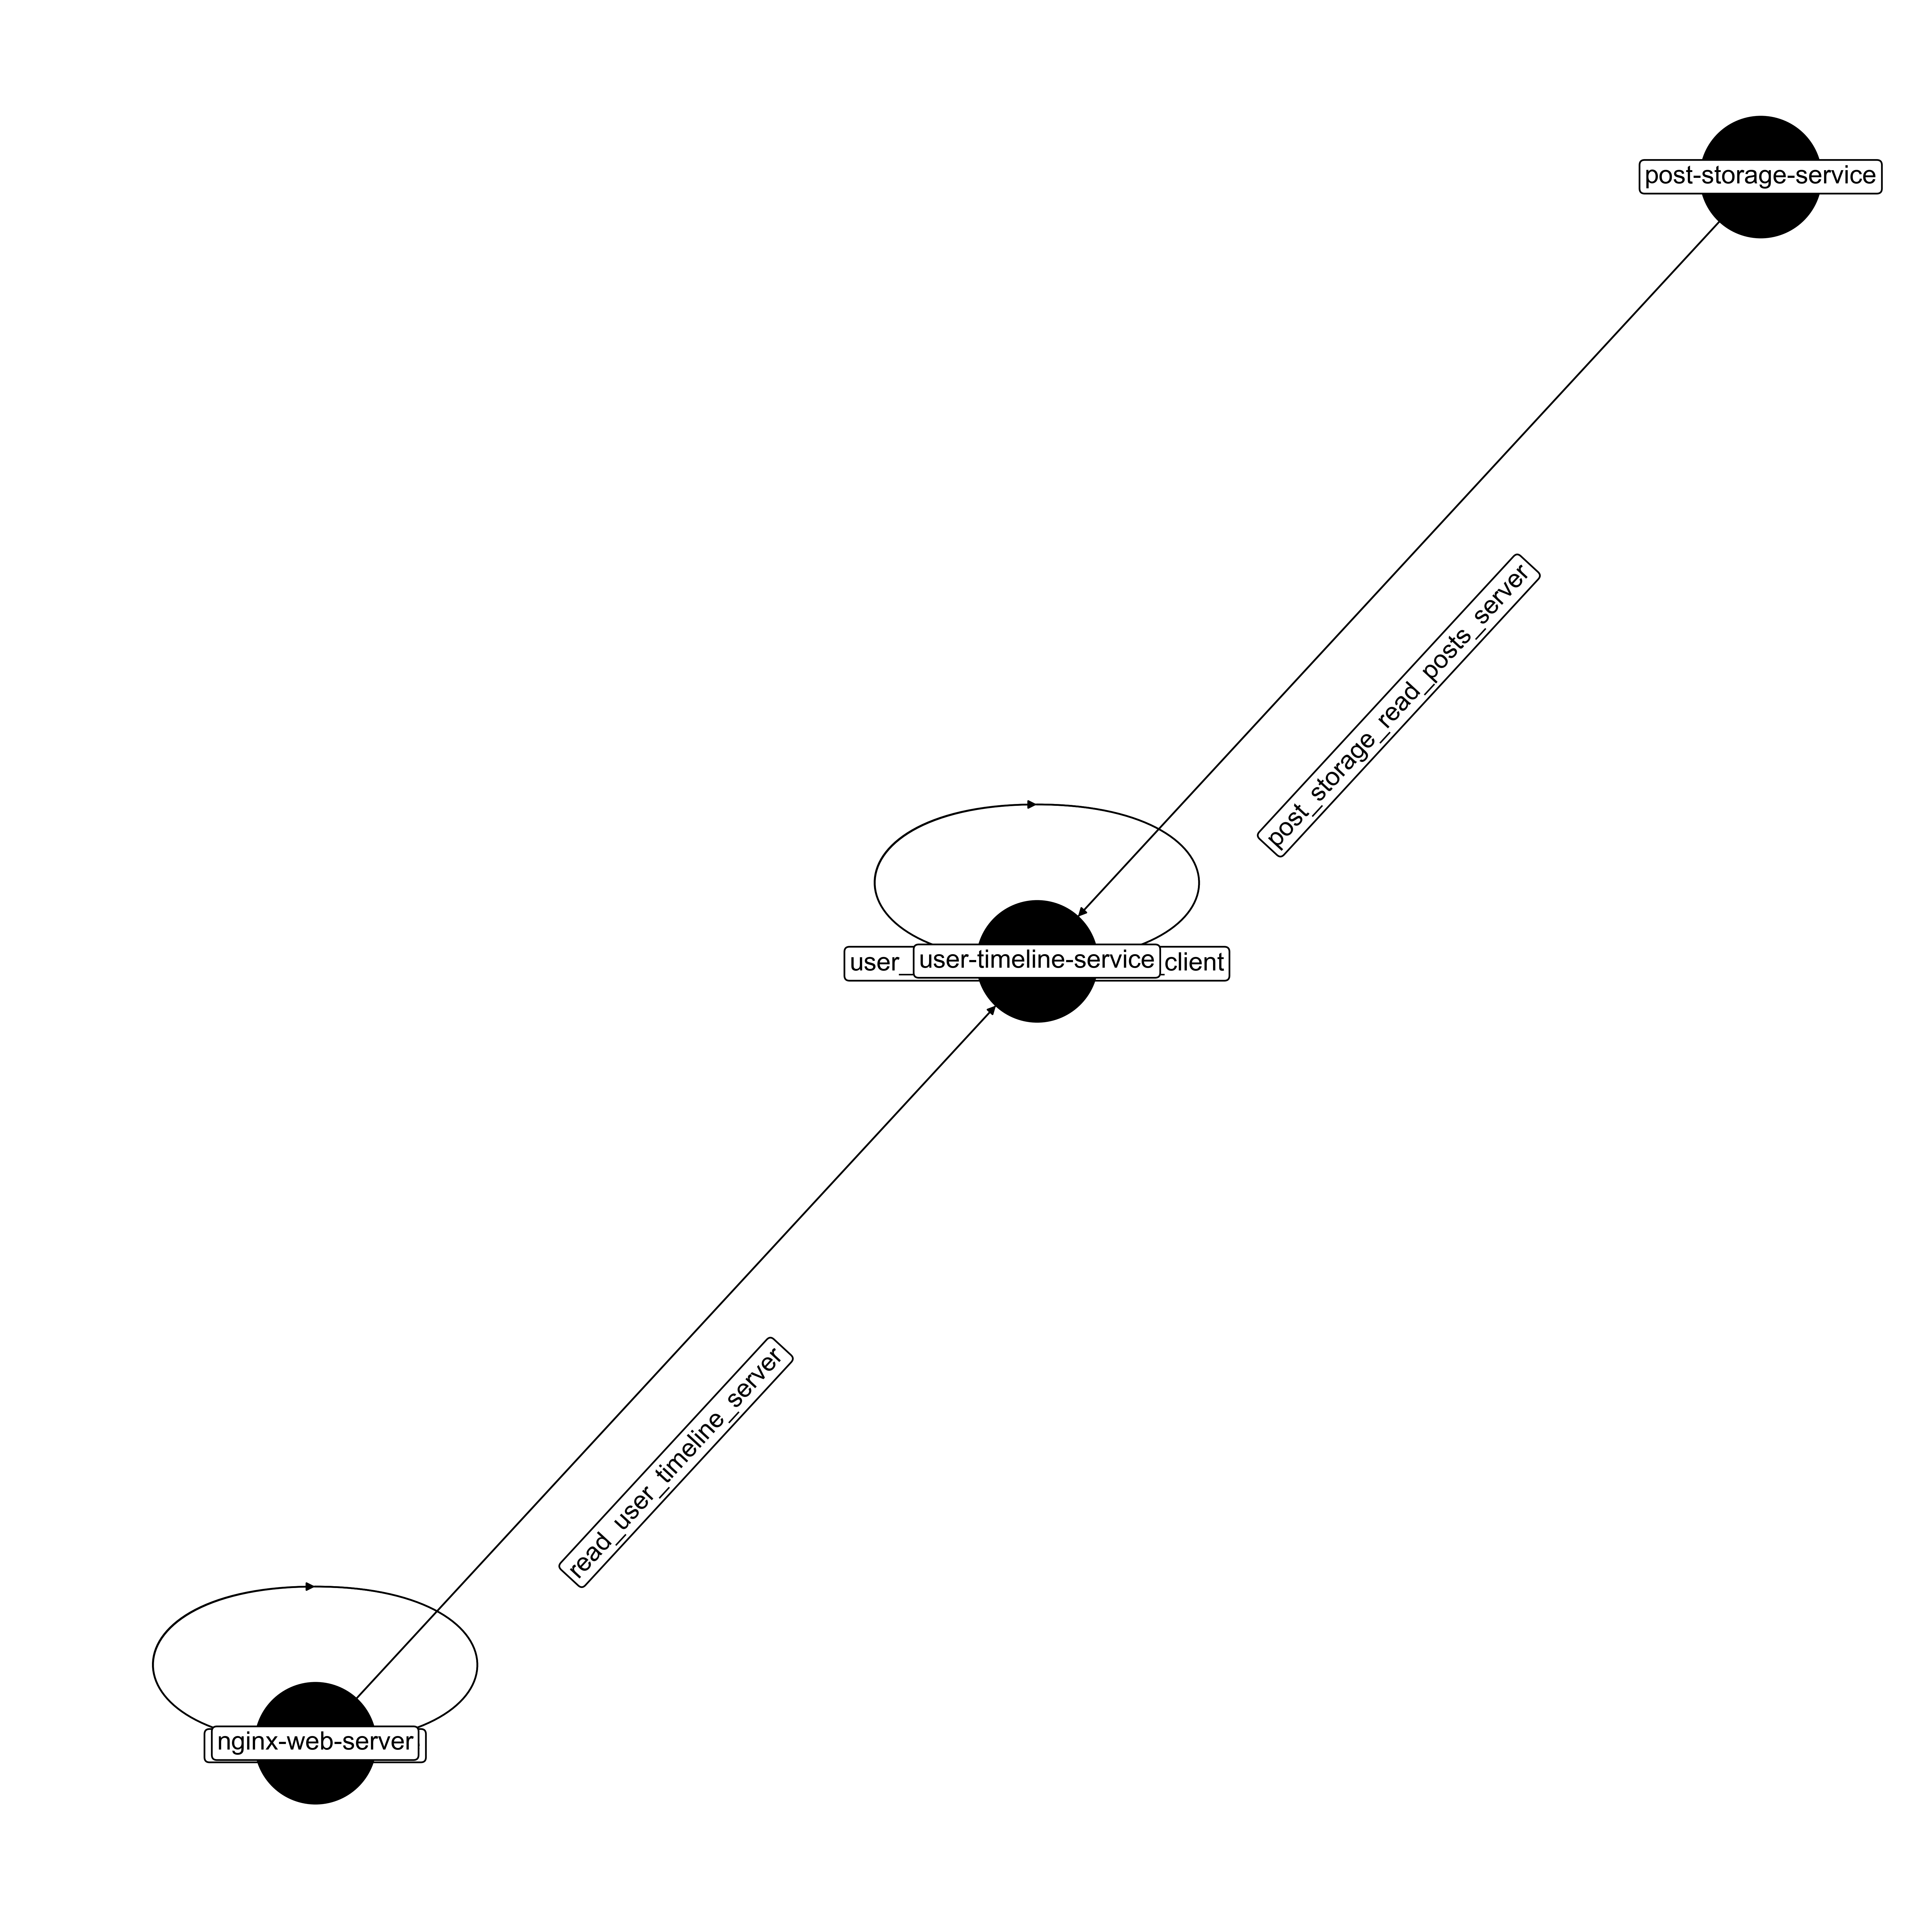

['nginx-web-server', '/wrk2-api/user-timeline/read', 'nginx-web-server']
['post-storage-service', 'post_storage_read_posts_server', 'user-timeline-service']
['nginx-web-server', 'ReadUserTimeline', 'nginx-web-server']
['user-timeline-service', 'user_timeline_redis_find_client', 'user-timeline-service']
['user-timeline-service', 'user_timeline_mongo_find_client', 'user-timeline-service']
['user-timeline-service', 'read_user_timeline_server', 'nginx-web-server']
[('post-storage-service', 'nginx-web-server')]
Common Neighbours
(post-storage-service, nginx-web-server) -> 1.00000000
Sorensen Index
(post-storage-service, nginx-web-server) -> 0.50000000
Salton Index
(post-storage-service, nginx-web-server) -> 0.57735027
Jaccard Index
(post-storage-service, nginx-web-server) -> 0.50000000
Resouce Allocation
(post-storage-service, nginx-web-server) -> 0.25000000
Adamic Adar
(post-storage-service, nginx-web-server) -> 0.72134752
Katz Index
(post-storage-service, nginx-web-server) -> 0.00002525
L

In [5]:
topology_based('social-network/sample-rate-100/nginx-web-server.json')

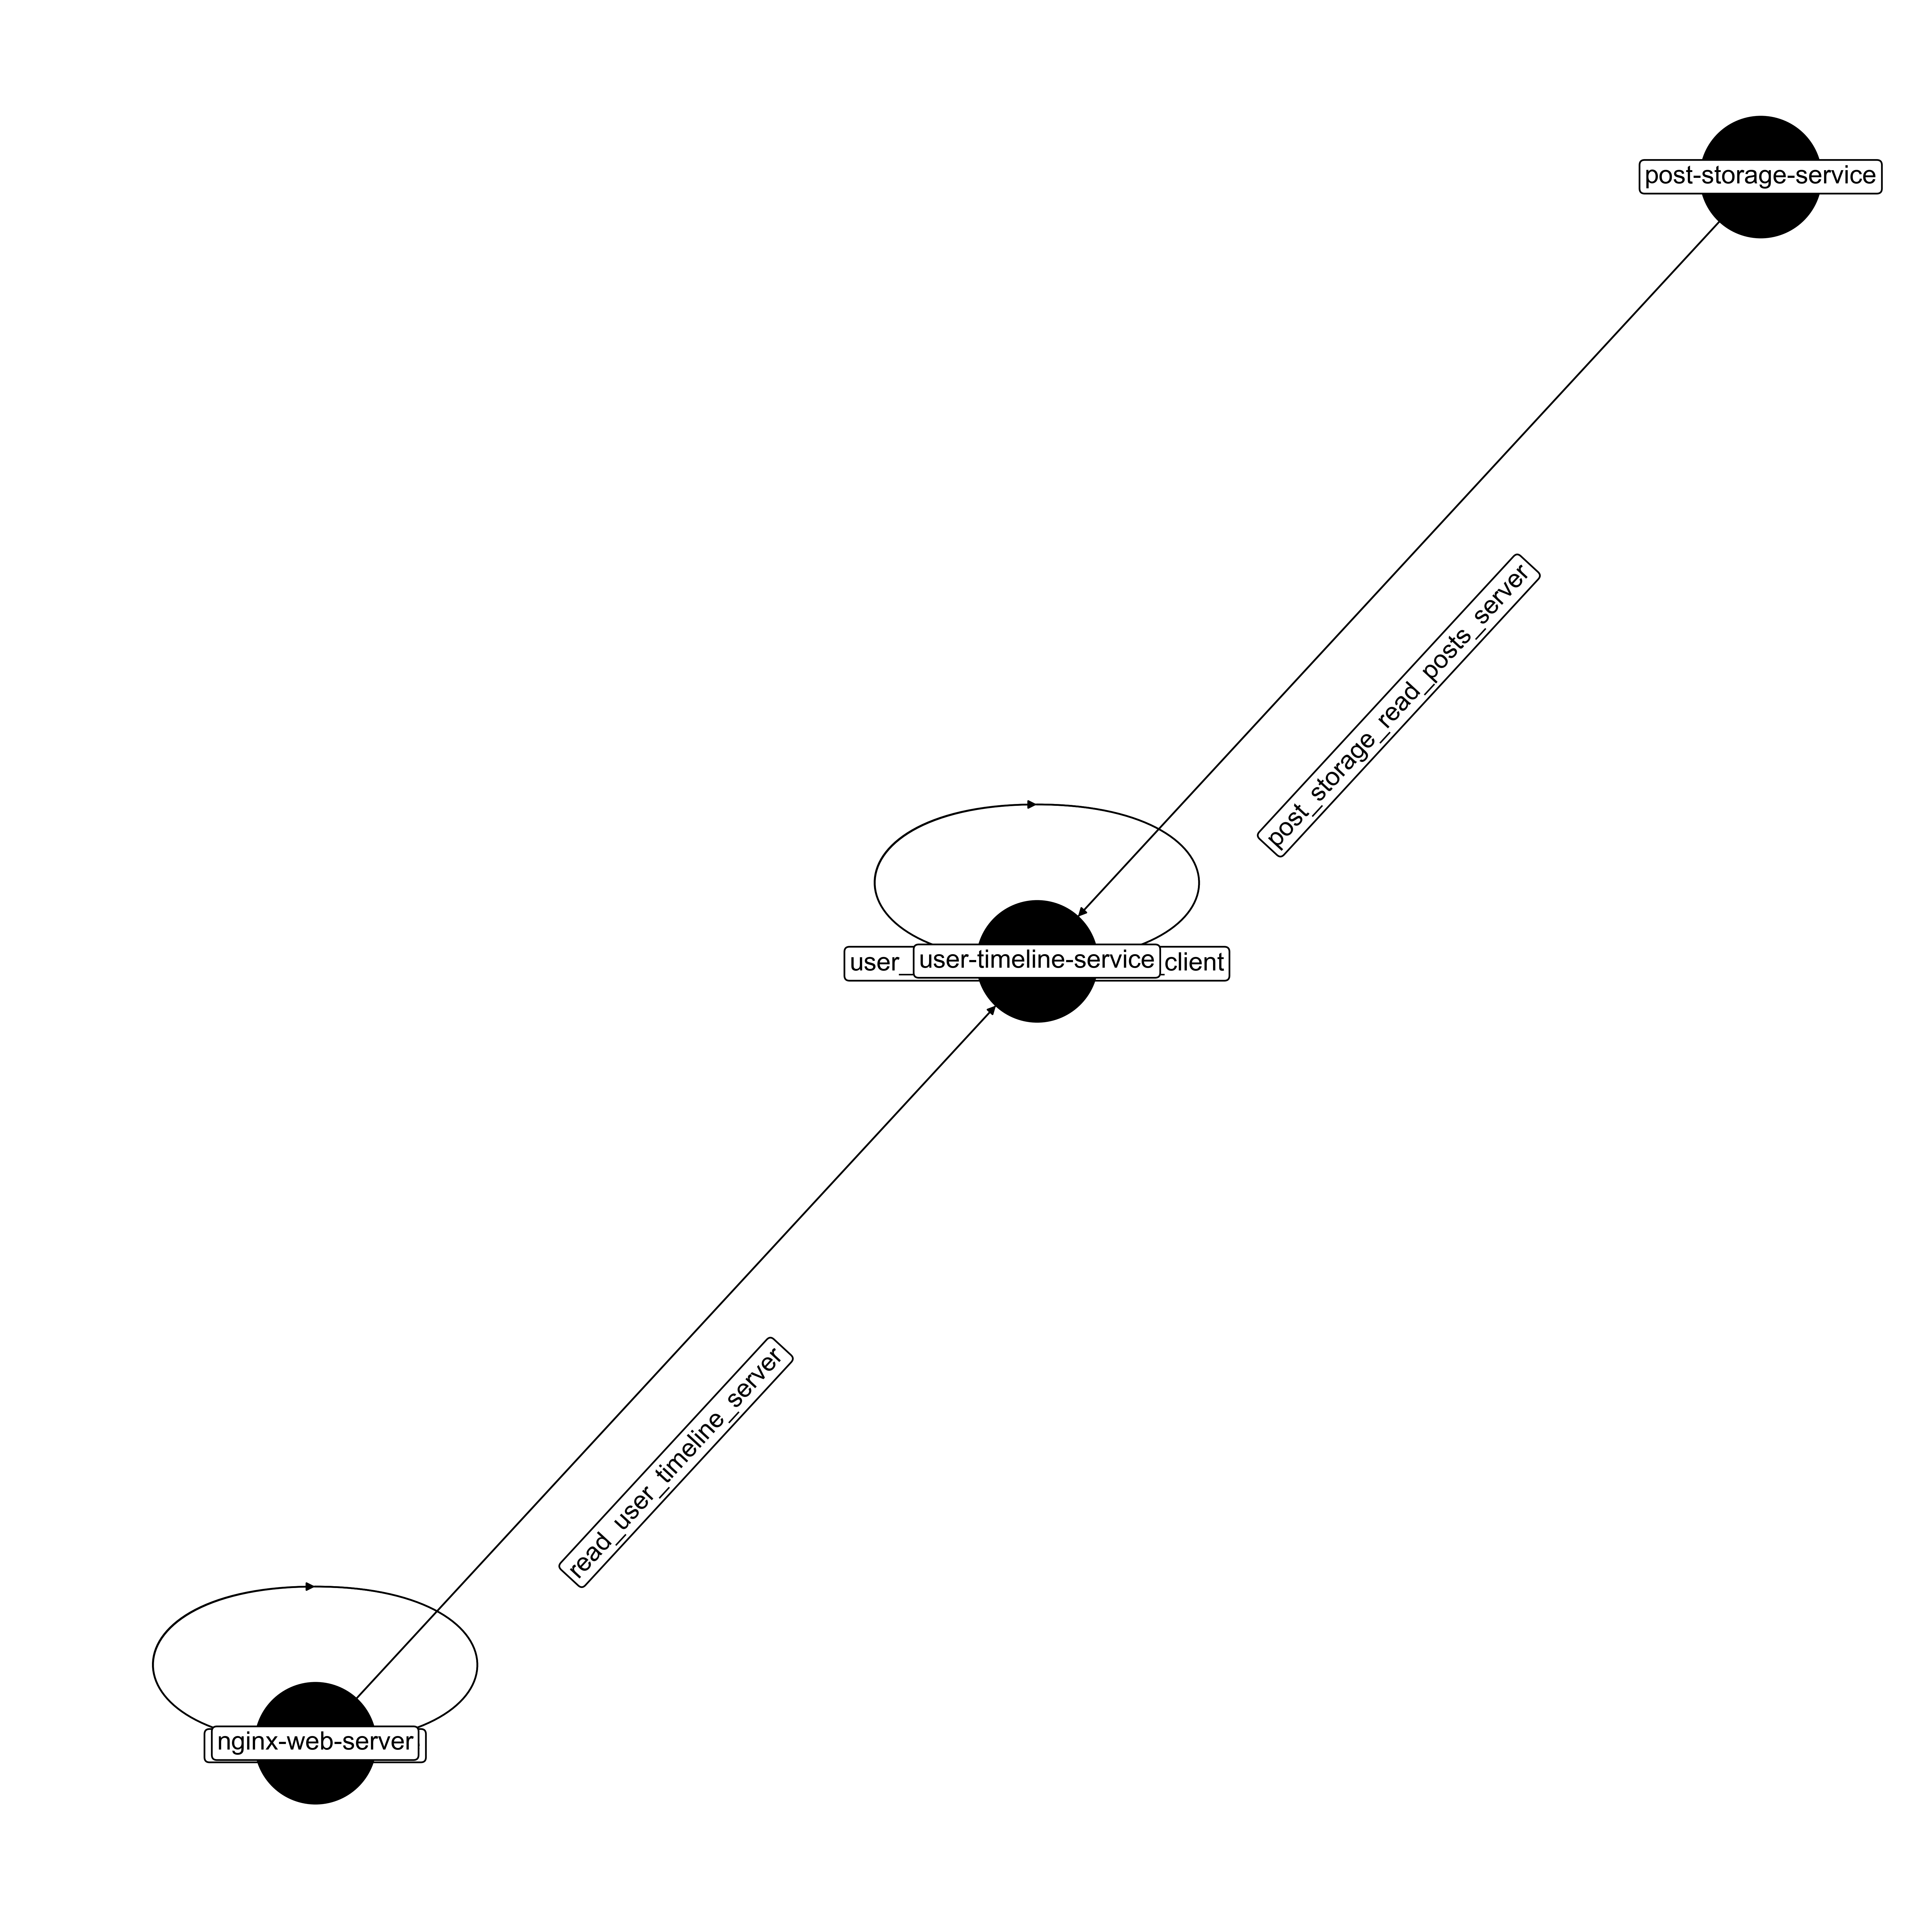

['nginx-web-server', '/wrk2-api/user-timeline/read', 'nginx-web-server']
['post-storage-service', 'post_storage_read_posts_server', 'user-timeline-service']
['nginx-web-server', 'ReadUserTimeline', 'nginx-web-server']
['user-timeline-service', 'user_timeline_redis_find_client', 'user-timeline-service']
['user-timeline-service', 'user_timeline_mongo_find_client', 'user-timeline-service']
['user-timeline-service', 'read_user_timeline_server', 'nginx-web-server']
[('post-storage-service', 'nginx-web-server')]
Common Neighbours
(post-storage-service, nginx-web-server) -> 1.00000000
Sorensen Index
(post-storage-service, nginx-web-server) -> 0.50000000
Salton Index
(post-storage-service, nginx-web-server) -> 0.57735027
Jaccard Index
(post-storage-service, nginx-web-server) -> 0.50000000
Resouce Allocation
(post-storage-service, nginx-web-server) -> 0.25000000
Adamic Adar
(post-storage-service, nginx-web-server) -> 0.72134752
Katz Index
(post-storage-service, nginx-web-server) -> 0.00002525
L

In [6]:
topology_based('social-network/sample-rate-100/post-storage-service.json')

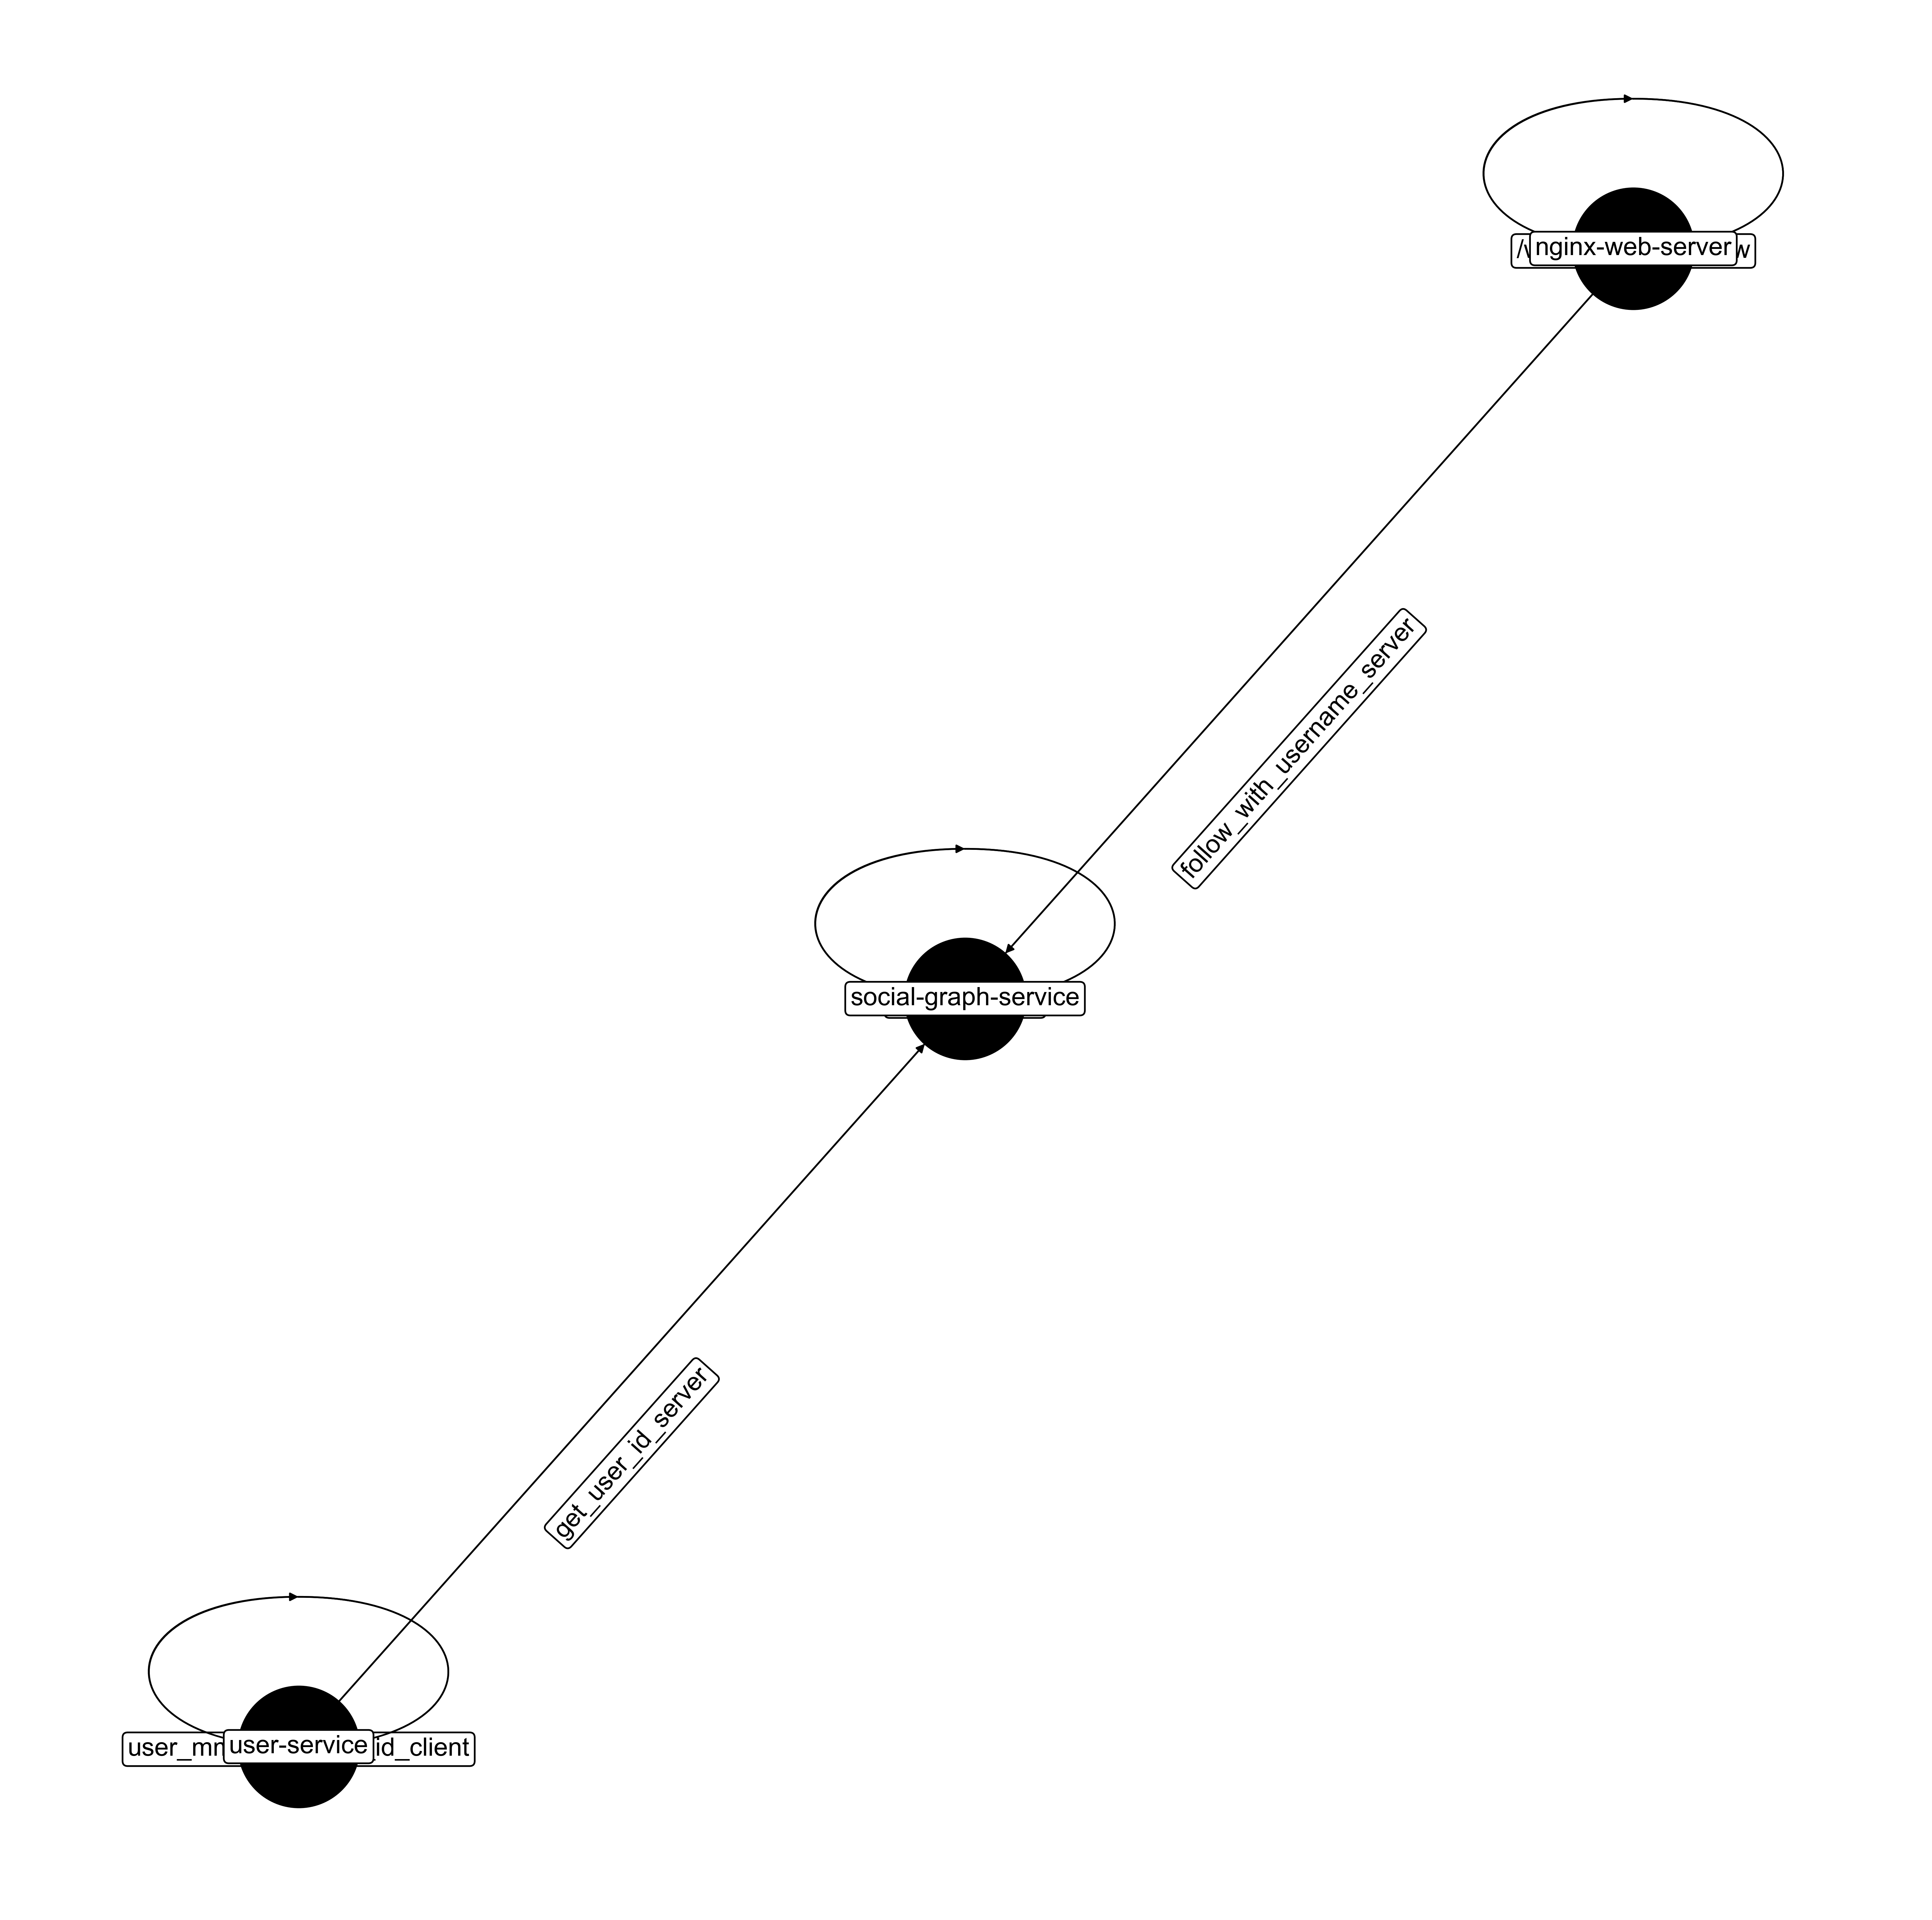

['nginx-web-server', 'Follow', 'nginx-web-server']
['nginx-web-server', '/wrk2-api/user/follow', 'nginx-web-server']
['user-service', 'user_mmc_get_user_id_client', 'user-service']
['user-service', 'get_user_id_server', 'social-graph-service']
['user-service', 'user_mmc_get_user_id_client', 'user-service']
['user-service', 'get_user_id_server', 'social-graph-service']
['social-graph-service', 'mongo_update_client', 'social-graph-service']
['social-graph-service', 'social_graph_redis_update_client', 'social-graph-service']
['social-graph-service', 'social_graph_mongo_update_client', 'social-graph-service']
['social-graph-service', 'follow_server', 'social-graph-service']
['social-graph-service', 'follow_with_username_server', 'nginx-web-server']
[('nginx-web-server', 'user-service')]
Common Neighbours
(nginx-web-server, user-service) -> 1.00000000
Sorensen Index
(nginx-web-server, user-service) -> 0.33333333
Salton Index
(nginx-web-server, user-service) -> 0.33333333
Jaccard Index
(ngin

In [7]:
topology_based('social-network/sample-rate-100/user-service.json')